# **Predicting tweet sentiment**

Dataset from https://www.kaggle.com/datasets/bhavikjikadara/tweets-dataset

**Context**

This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the Twitter API. The tweets have been annotated (0 = negative, 4 = positive) and can be used to detect sentiment.

**Content**

It contains the following 6 fields:

* target: the polarity of the tweet (0 = negative and 4 = positive)
* ids: The id of the tweet ( 2087)
* date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* flag: The query (lyx). If there is no query, then this value is NO_QUERY.
* user: the user that tweeted.
* text: the text of the tweet.

## **1. Exploratory Data Analysis** 

In [1]:
# import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


# text processing libraries
import re
import contractions

from collections import Counter
# import string
import nltk
# import warnings
# %matplotlib inline
# warnings.filterwarnings("ignore")
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\macie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\macie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Pandas and Numpy have been used for data manipulation and numerical calculations

Matplotlib and Seaborn have been used for data visualizations

In [2]:
# import data   
tweets = pd.read_csv("..//data//tweets.csv", encoding="latin-1")

In [3]:
tweets.head()

,Target,ID,Date,flag,User,Text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


## **2. Splitting dataset into training, valid and testing parts**

In [4]:
x_train_valid, x_test, y_train_valid, y_test = train_test_split(
    tweets.drop(columns=['Target']), # X
    tweets['Target'], # y
    test_size=0.3, random_state=42)

In [5]:
x_train_valid.shape, y_train_valid.shape, x_test.shape, y_test.shape 

((734002, 5), (734002,), (314573, 5), (314573,))

In [6]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_valid, # X
    y_train_valid, # y
    test_size=0.3, random_state=42)

In [7]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((513801, 5), (513801,), (220201, 5), (220201,))

In [100]:
#x_train.to_csv("..//data//x_train.csv", index=False)
#y_train.to_csv("..//data//y_train.csv", index=False)
#x_valid.to_csv("..//data//x_valid.csv", index=False)
#y_valid.to_csv("..//data//y_valid.csv", index=False)
#x_test.to_csv("..//data//x_test.csv", index=False)
#y_test.to_csv("..//data//y_test.csv", index=False)

## EDA


In [12]:
# check the shape of the dataframe
df = x_train
print("Shape of the dataframe:", df.shape)

Shape of the dataframe: (513801, 6)


In [13]:
# display the first few rows of the dataframe
df.head()

,Target,ID,Date,flag,User,Text
810677,4,1469845676,Tue Apr 07 07:35:21 PDT 2009,NO_QUERY,TheTaraBull,"working, listening to KMPS, happy my boss &amp..."
684982,0,2250659925,Sat Jun 20 01:07:37 PDT 2009,NO_QUERY,NickiePhilbin,We both know she is late for &quot;at 11&quot;
954730,4,1824898973,Sun May 17 03:26:07 PDT 2009,NO_QUERY,klaus789,don't bogart that joint my friend ? http://bl...
142760,0,1881553825,Fri May 22 04:58:33 PDT 2009,NO_QUERY,DesireeO,I'm so sick of being sick! I don't want to mis...
200331,0,1971641083,Sat May 30 07:34:01 PDT 2009,NO_QUERY,ChrisDuano,im pretty sure i went to bed about... 2 hours ...


In [14]:
# display the last few rows of the dataframe
df.tail()

,Target,ID,Date,flag,User,Text
1023596,4,1883036618,Fri May 22 07:54:14 PDT 2009,NO_QUERY,dreeziebaby,Good morning sunshine!! http://myloc.me/1oef
281932,0,1992472320,Mon Jun 01 08:48:34 PDT 2009,NO_QUERY,NorwichMassage,@MassageAlumni Is the website (http://www.mass...
828817,4,1557077059,Sun Apr 19 01:53:10 PDT 2009,NO_QUERY,lovesmugs,@bringsatowel I listened to the iTunes samples...
683555,0,2250304235,Sat Jun 20 00:11:20 PDT 2009,NO_QUERY,mugunthkumar,@cedric_chee I use palringo for chat and Fring...
603860,0,2221776747,Thu Jun 18 05:59:17 PDT 2009,NO_QUERY,c34elebrity,I'm uploading photos of my friends....but it d...


In [15]:
# display information about data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 513801 entries, 810677 to 603860
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Target  513801 non-null  int64 
 1   ID      513801 non-null  int64 
 2   Date    513801 non-null  object
 3   flag    513801 non-null  object
 4   User    513801 non-null  object
 5   Text    513801 non-null  object
dtypes: int64(2), object(4)
memory usage: 27.4+ MB


In [16]:
# check for duplication
df.nunique()

Target         2
ID        513678
Date      397695
flag           1
User      311235
Text      509344
dtype: int64

In [17]:
# check for missing values
df.isnull().sum()

Target    0
ID        0
Date      0
flag      0
User      0
Text      0
dtype: int64

In [18]:
# summary statistics of numerical columns
df.describe()

,Target,ID
count,513801.000000,5.138010e+05
mean,0.947114,1.976257e+09
std,1.700422,2.301308e+08
min,0.000000,1.467811e+09
25%,0.000000,1.824564e+09
50%,0.000000,1.991022e+09
75%,0.000000,2.198871e+09
max,4.000000,2.329206e+09


**Data reduction**

Some columns or variables can be dropped if they do not add value to our analysis

In our dataset, columns ID, Date, flag, User don’t have any predictive power to predict the dependent variable

In [19]:
data = df.drop(['ID', 'Date', 'flag', 'User'], axis = 'columns')
data

,Target,Text
810677,4,"working, listening to KMPS, happy my boss &amp..."
684982,0,We both know she is late for &quot;at 11&quot;
954730,4,don't bogart that joint my friend ? http://bl...
142760,0,I'm so sick of being sick! I don't want to mis...
200331,0,im pretty sure i went to bed about... 2 hours ...
...,...,...
1023596,4,Good morning sunshine!! http://myloc.me/1oef
281932,0,@MassageAlumni Is the website (http://www.mass...
828817,4,@bringsatowel I listened to the iTunes samples...
683555,0,@cedric_chee I use palringo for chat and Fring...


**Data cleaning**

Some names of the variables are not relevant and not easy to understand

Some data may have data entry errors, and some variables may need data type conversion. We need to fix this issue in the data

In [20]:
# adjusting target values
data['Target'] = data['Target'].replace(4, 1)
data

,Target,Text
810677,1,"working, listening to KMPS, happy my boss &amp..."
684982,0,We both know she is late for &quot;at 11&quot;
954730,1,don't bogart that joint my friend ? http://bl...
142760,0,I'm so sick of being sick! I don't want to mis...
200331,0,im pretty sure i went to bed about... 2 hours ...
...,...,...
1023596,1,Good morning sunshine!! http://myloc.me/1oef
281932,0,@MassageAlumni Is the website (http://www.mass...
828817,1,@bringsatowel I listened to the iTunes samples...
683555,0,@cedric_chee I use palringo for chat and Fring...


In [21]:
# removing unnecessary user tags
data['Text'] = data['Text'].replace(r"@\w+", "", regex=True)
data


,Target,Text
810677,1,"working, listening to KMPS, happy my boss &amp..."
684982,0,We both know she is late for &quot;at 11&quot;
954730,1,don't bogart that joint my friend ? http://bl...
142760,0,I'm so sick of being sick! I don't want to mis...
200331,0,im pretty sure i went to bed about... 2 hours ...
...,...,...
1023596,1,Good morning sunshine!! http://myloc.me/1oef
281932,0,Is the website (http://www.massagealumni.com)...
828817,1,I listened to the iTunes samples..my fav albu...
683555,0,I use palringo for chat and Fring for Voice c...


In [22]:
# resolving contractions (and slang)
data['Text'] = data['Text'].apply(lambda x: contractions.fix(x))
data

,Target,Text
810677,1,"working, listening to KMPS, happy my boss &amp..."
684982,0,We both know she is late for &quot;at 11&quot;
954730,1,do not bogart that joint my friend ? http://b...
142760,0,I am so sick of being sick! I do not want to m...
200331,0,i am pretty sure i went to bed about... 2 hour...
...,...,...
1023596,1,Good morning sunshine!! http://myloc.me/1oef
281932,0,Is the website (http://www.massagealumni.com)...
828817,1,I listened to the iTunes samples..my fav albu...
683555,0,I use palringo for chat and Fring for Voice c...


In [23]:
# removing punctuation marks
data['Text'] = data['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
data


,Target,Text
810677,1,working listening to KMPS happy my boss amp th...
684982,0,We both know she is late for quotat 11quot
954730,1,do not bogart that joint my friend httpblipf...
142760,0,I am so sick of being sick I do not want to mi...
200331,0,i am pretty sure i went to bed about 2 hours a...
...,...,...
1023596,1,Good morning sunshine httpmylocme1oef
281932,0,Is the website httpwwwmassagealumnicom down ...
828817,1,I listened to the iTunes samplesmy fav albums...
683555,0,I use palringo for chat and Fring for Voice c...


In [24]:
# lowercasing letters in the text
data['Text'] = data['Text'].str.lower()
data


,Target,Text
810677,1,working listening to kmps happy my boss amp th...
684982,0,we both know she is late for quotat 11quot
954730,1,do not bogart that joint my friend httpblipf...
142760,0,i am so sick of being sick i do not want to mi...
200331,0,i am pretty sure i went to bed about 2 hours a...
...,...,...
1023596,1,good morning sunshine httpmylocme1oef
281932,0,is the website httpwwwmassagealumnicom down ...
828817,1,i listened to the itunes samplesmy fav albums...
683555,0,i use palringo for chat and fring for voice c...


**Visualization**

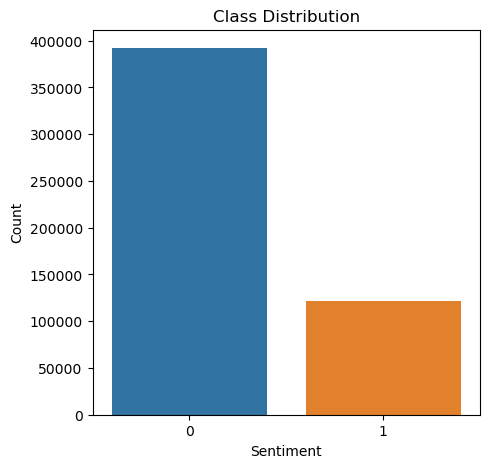

In [25]:
# visualize class distribution
plt.figure(figsize=(5, 5))
sns.countplot(x = 'Target' , data = data)
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

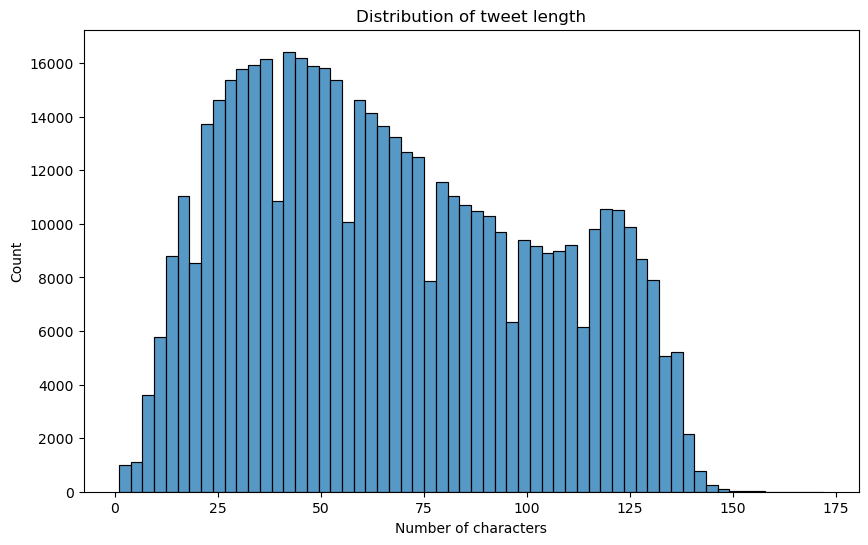

In [26]:
# explore tweet length
data['characters'] = data['Text'].apply(lambda x: len(x))

# visualize tweet length distribution
plt.figure(figsize = (10, 6))
sns.histplot(data['characters'], bins = 60)
plt.title('Distribution of tweet length')
plt.xlabel('Number of characters')
plt.ylabel('Count')
plt.show()

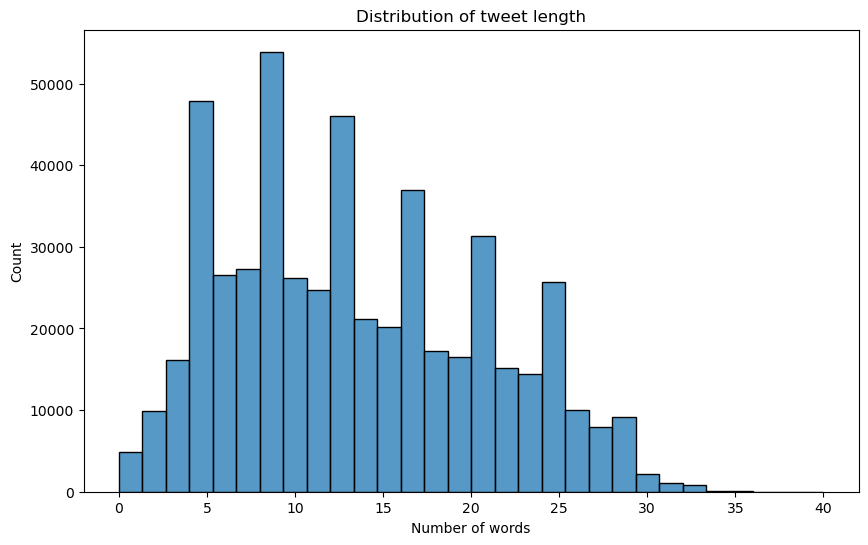

In [27]:
# explore tweet length
data['words'] = data['Text'].apply(lambda x: len(x.split()))

# visualize tweet length distribution
plt.figure(figsize = (10, 6))
sns.histplot(data['words'], bins = 30)
plt.title('Distribution of tweet length')
plt.xlabel('Number of words')
plt.ylabel('Count')
plt.show()

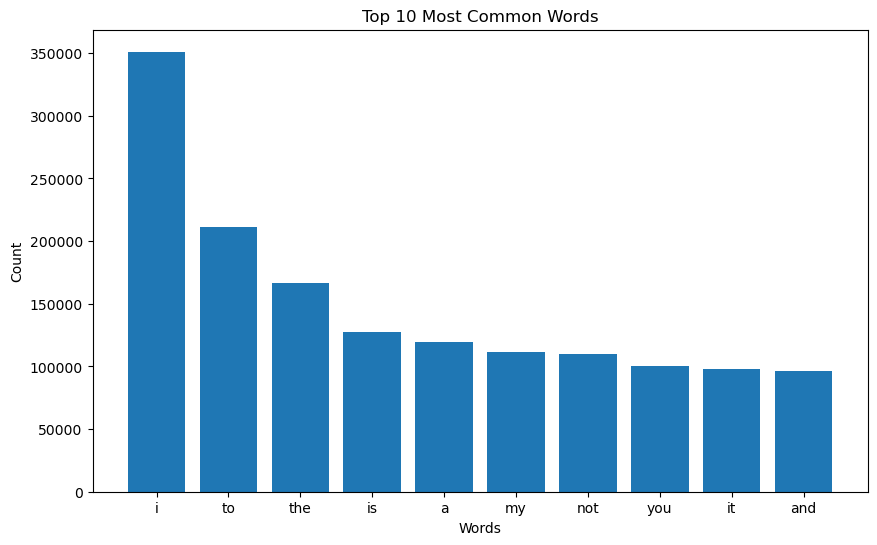

In [28]:

# combine all the text into a single string
all_text = ' '.join(data['Text'])

# split the text into individual words
words = all_text.split()

# count the frequency of each word
word_counts = Counter(words)

# get the top 10 most common words
top_10_words = word_counts.most_common(10)

# extract the words and their counts
top_10_words, top_10_counts = zip(*top_10_words)

# plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_10_words, top_10_counts)
plt.title('Top 10 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.show()


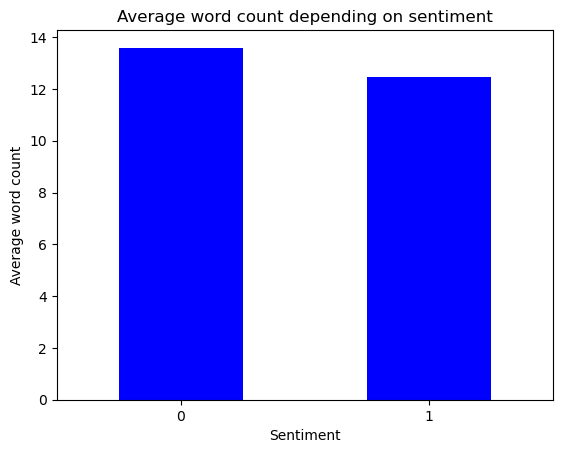

In [29]:
# average word count depending on sentiment

df = data.groupby("Target").words.agg("mean")

df.plot(kind = 'bar', color = 'blue')

plt.title('Average word count depending on sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average word count')
plt.xticks(rotation = 0)  
plt.show()

In [30]:
# is # in tweet?

data['has_hashtag'] = tweets['Text'].str.contains(r'#\w+')
data

,Target,Text,characters,words,has_hashtag
810677,1,working listening to kmps happy my boss amp th...,83,16,False
684982,0,we both know she is late for quotat 11quot,43,9,False
954730,1,do not bogart that joint my friend httpblipf...,52,8,False
142760,0,i am so sick of being sick i do not want to mi...,64,15,False
200331,0,i am pretty sure i went to bed about 2 hours a...,72,18,False
...,...,...,...,...,...
1023596,1,good morning sunshine httpmylocme1oef,38,4,False
281932,0,is the website httpwwwmassagealumnicom down ...,71,11,False
828817,1,i listened to the itunes samplesmy fav albums...,118,21,False
683555,0,i use palringo for chat and fring for voice c...,121,24,False


In [31]:
# is hashtag present in negatives tweets?

data[data['Target'] == 0]['has_hashtag'].value_counts().apply(lambda x: x / len(data[data['Target'] == 0]) * 100)


False    98.090752
True      1.909248
Name: has_hashtag, dtype: float64

In [32]:
# is hashtag present in positives tweets?

data[data['Target'] == 1]['has_hashtag'].value_counts().apply(lambda x: x / len(data[data['Target'] == 1]) * 100)

False    97.416507
True      2.583493
Name: has_hashtag, dtype: float64

In [33]:
# is "not" in tweet?

data['has_not'] = data['Text'].str.contains('not')
data

,Target,Text,characters,words,has_hashtag,has_not
810677,1,working listening to kmps happy my boss amp th...,83,16,False,False
684982,0,we both know she is late for quotat 11quot,43,9,False,False
954730,1,do not bogart that joint my friend httpblipf...,52,8,False,True
142760,0,i am so sick of being sick i do not want to mi...,64,15,False,True
200331,0,i am pretty sure i went to bed about 2 hours a...,72,18,False,False
...,...,...,...,...,...,...
1023596,1,good morning sunshine httpmylocme1oef,38,4,False,False
281932,0,is the website httpwwwmassagealumnicom down ...,71,11,False,True
828817,1,i listened to the itunes samplesmy fav albums...,118,21,False,True
683555,0,i use palringo for chat and fring for voice c...,121,24,False,True


In [34]:
# is "not" present in negatives tweets?

data[data['Target'] == 0]['has_not'].value_counts().apply(lambda x: x / len(data[data['Target'] == 0]) * 100)

False    70.662563
True     29.337437
Name: has_not, dtype: float64

In [35]:
# is "not" present in positives tweets?

data[data['Target'] == 1]['has_not'].value_counts().apply(lambda x: x / len(data[data['Target'] == 1]) * 100)

False    86.119171
True     13.880829
Name: has_not, dtype: float64

In [36]:
# extract hour from the Date column

data['Hour'] = pd.to_datetime(tweets['Date']).dt.hour
data


c:\Users\flang\anaconda3\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


,Target,Text,characters,words,has_hashtag,has_not,Hour
810677,1,working listening to kmps happy my boss amp th...,83,16,False,False,7
684982,0,we both know she is late for quotat 11quot,43,9,False,False,1
954730,1,do not bogart that joint my friend httpblipf...,52,8,False,True,3
142760,0,i am so sick of being sick i do not want to mi...,64,15,False,True,4
200331,0,i am pretty sure i went to bed about 2 hours a...,72,18,False,False,7
...,...,...,...,...,...,...,...
1023596,1,good morning sunshine httpmylocme1oef,38,4,False,False,7
281932,0,is the website httpwwwmassagealumnicom down ...,71,11,False,True,8
828817,1,i listened to the itunes samplesmy fav albums...,118,21,False,True,1
683555,0,i use palringo for chat and fring for voice c...,121,24,False,True,0


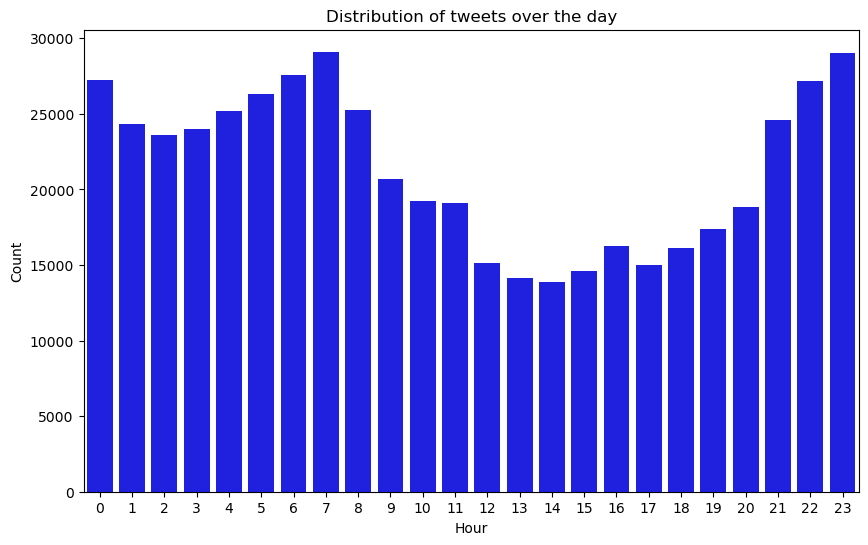

In [37]:
# visualize the distribution of tweets over the day

plt.figure(figsize=(10, 6))
sns.countplot(x = 'Hour', data = data, color = 'blue')
plt.title('Distribution of tweets over the day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()


<Figure size 1500x600 with 0 Axes>

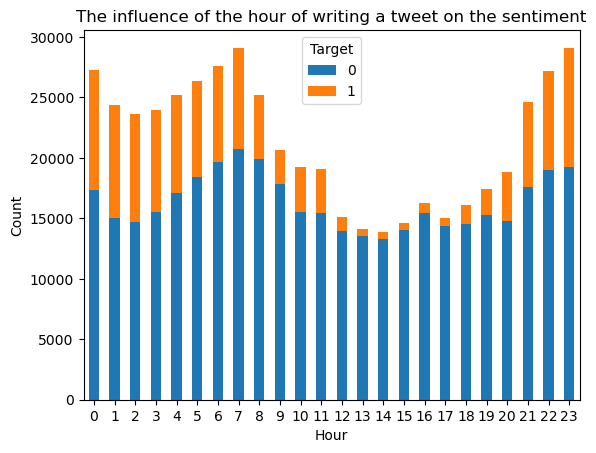

In [38]:
# visualize the the influence of the hour of writing a tweet on the Target variable
hourly_target_counts = data.groupby('Hour')['Target'].value_counts().unstack(fill_value=0)
plt.figure(figsize=(15, 6))
hourly_target_counts.plot(kind='bar', stacked=True)

plt.title('The influence of the hour of writing a tweet on the sentiment')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.xticks(rotation = 0)  

plt.show()

In [39]:
# deleting words which have less characters than 3

data['clean_text'] = data["Text"].apply(lambda x: " ".join([w for w in x.split() if len(w)>=3]))
data

,Target,Text,characters,words,has_hashtag,has_not,Hour,clean_text
810677,1,working listening to kmps happy my boss amp th...,83,16,False,False,7,working listening kmps happy boss amp the mech...
684982,0,we both know she is late for quotat 11quot,43,9,False,False,1,both know she late for quotat 11quot
954730,1,do not bogart that joint my friend httpblipf...,52,8,False,True,3,not bogart that joint friend httpblipfm6gg5t
142760,0,i am so sick of being sick i do not want to mi...,64,15,False,True,4,sick being sick not want miss another summer
200331,0,i am pretty sure i went to bed about 2 hours a...,72,18,False,False,7,pretty sure went bed about hours ago and again...
...,...,...,...,...,...,...,...,...
1023596,1,good morning sunshine httpmylocme1oef,38,4,False,False,7,good morning sunshine httpmylocme1oef
281932,0,is the website httpwwwmassagealumnicom down ...,71,11,False,True,8,the website httpwwwmassagealumnicom down canno...
828817,1,i listened to the itunes samplesmy fav albums...,118,21,False,True,1,listened the itunes samplesmy fav albums are c...
683555,0,i use palringo for chat and fring for voice c...,121,24,False,True,0,use palringo for chat and fring for voice call...


In [40]:
# individual words considered as tokens

tokenized_tweet = data['clean_text'].apply(lambda x: x.split())
tokenized_tweet

810677     [working, listening, kmps, happy, boss, amp, t...
684982          [both, know, she, late, for, quotat, 11quot]
954730     [not, bogart, that, joint, friend, httpblipfm6...
142760     [sick, being, sick, not, want, miss, another, ...
200331     [pretty, sure, went, bed, about, hours, ago, a...
                                 ...                        
1023596           [good, morning, sunshine, httpmylocme1oef]
281932     [the, website, httpwwwmassagealumnicom, down, ...
828817     [listened, the, itunes, samplesmy, fav, albums...
683555     [use, palringo, for, chat, and, fring, for, vo...
603860      [uploading, photos, friendsbut, does, not, work]
Name: clean_text, Length: 513801, dtype: object

In [41]:
# stem the words
#stemmer = PorterStemmer()

#tokenized_tweet = tokenized_tweet.apply(lambda s: [stemmer.stem(word) for word in s]) # stemming
#tokenized_tweet
# Initialize wordnet lemmatizer only on verbs - makes the biggest sense
wnl = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda s: [wnl.lemmatize(word, pos="v") for word in s]) # lemmatization

In [42]:
tokenized_tweet.iloc[34]

['listen', 'the', 'album', 'the', 'jackson', 'history']

In [43]:
# combining to sentences
combined_sentences = [' '.join(tokens) for tokens in tokenized_tweet]
data['combined_tweet'] = combined_sentences
data

,Target,Text,characters,words,has_hashtag,has_not,Hour,clean_text,combined_tweet
810677,1,working listening to kmps happy my boss amp th...,83,16,False,False,7,working listening kmps happy boss amp the mech...,work listen kmps happy boss amp the mechanic b...
684982,0,we both know she is late for quotat 11quot,43,9,False,False,1,both know she late for quotat 11quot,both know she late for quotat 11quot
954730,1,do not bogart that joint my friend httpblipf...,52,8,False,True,3,not bogart that joint friend httpblipfm6gg5t,not bogart that joint friend httpblipfm6gg5t
142760,0,i am so sick of being sick i do not want to mi...,64,15,False,True,4,sick being sick not want miss another summer,sick be sick not want miss another summer
200331,0,i am pretty sure i went to bed about 2 hours a...,72,18,False,False,7,pretty sure went bed about hours ago and again...,pretty sure go bed about hours ago and again ahhh
...,...,...,...,...,...,...,...,...,...
1023596,1,good morning sunshine httpmylocme1oef,38,4,False,False,7,good morning sunshine httpmylocme1oef,good morning sunshine httpmylocme1oef
281932,0,is the website httpwwwmassagealumnicom down ...,71,11,False,True,8,the website httpwwwmassagealumnicom down canno...,the website httpwwwmassagealumnicom down canno...
828817,1,i listened to the itunes samplesmy fav albums...,118,21,False,True,1,listened the itunes samplesmy fav albums are c...,listen the itunes samplesmy fav albums be cens...
683555,0,i use palringo for chat and fring for voice c...,121,24,False,True,0,use palringo for chat and fring for voice call...,use palringo for chat and fring for voice call...


C:\Users\flang\AppData\Local\Temp\ipykernel_14376\208684624.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


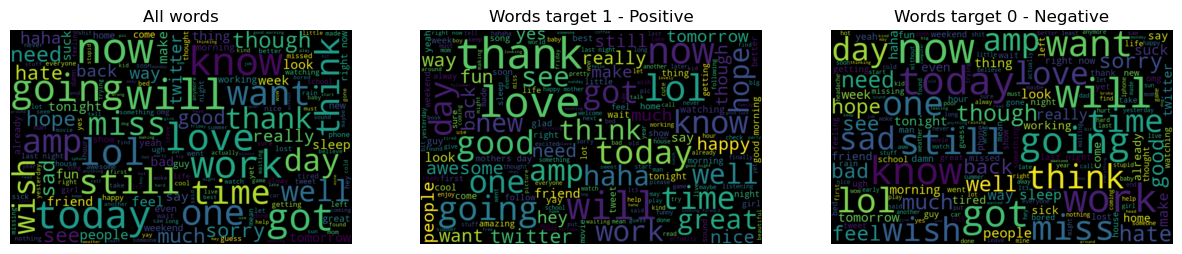

In [44]:
all_words = ' '.join([text for text in data['clean_text']])
all_words_pos = ' '.join([text for text in data['clean_text'][data['Target'] == 1]])
all_words_neg = ' '.join([text for text in data['clean_text'][data['Target'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)
wordcloud_pos = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words_pos)
wordcloud_neg = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words_neg)

# plot the graph

fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(wordcloud, interpolation="bilinear")
ax[0].set_title('All words')
ax[0].axis('off')
ax[1].imshow(wordcloud_pos, interpolation="bilinear")
ax[1].set_title('Words target 1 - Positive')
ax[1].axis('off')
ax[2].imshow(wordcloud_neg, interpolation="bilinear")
ax[2].set_title('Words target 0 - Negative')
ax[2].axis('off')
fig.show()

In [68]:
def hashtag_extract(tweetss):
    hashtags = []
    for tweet in tweetss:
        ht = re.findall(r"#(\w+)", tweet)
        hashtags.append(ht)
    return hashtags

In [83]:
# extracting hashtags from positive tweets
ht_positive = hashtag_extract(x_train['Text'][data['Target'] == 1])

# extracting hashtags from negative tweets
ht_negative = hashtag_extract(x_train['Text'][data['Target'] == 0])

In [84]:
# unnest list 
ht_positive = sum(ht_positive, [])
ht_negative = sum(ht_negative, [])

In [85]:
ht_positive[:5]

['followfriday', 'ff', 'Beijing', 'followfriday', 'CSS_Sprites']

In [86]:
ht_negative[:5]

['followfriday', 'squarespace', 'WeirdAl', 'myweakness', 'ctbf']

In [87]:
# converting dictionary to dataframe
freq = nltk.FreqDist(ht_positive)
d = pd.DataFrame({'Hashtag': list(freq.keys()), 
                  'Count': list(freq.values())
                  })
d.sort_values(by='Count', ascending=False)

,Hashtag,Count
0,followfriday,397
62,fb,92
54,asot400,78
29,FollowFriday,69
55,shaunjumpnow,66
...,...,...
736,stalkingsaturday,1
734,babes,1
733,sexy,1
732,ideaparty,1


Text(0.5, 1.0, 'Top 10 most frequent hashtags in positive tweets')

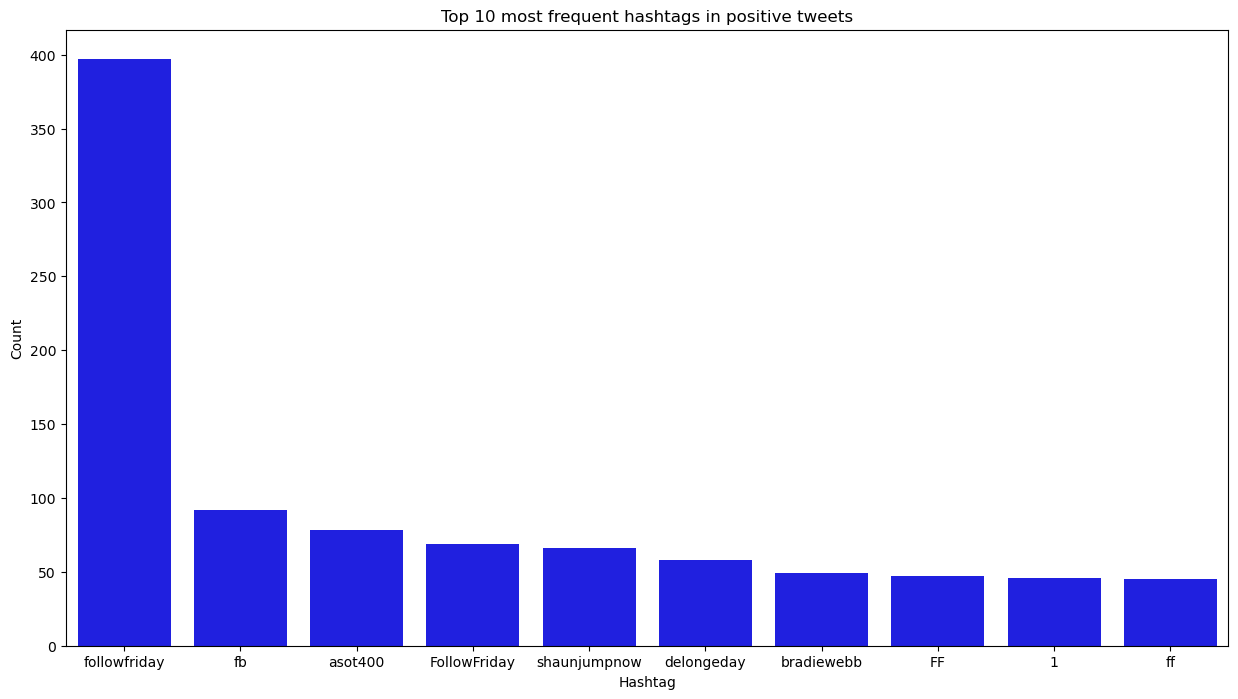

In [88]:
# selecting top 10 most frequent hashtags positive
d = d.nlargest(columns="Count", n = 10)
plt.figure(figsize=(15,8))
sns.barplot(data=d, x= "Hashtag", y = "Count", color="blue")
plt.title('Top 10 most frequent hashtags in positive tweets')

In [89]:
# converting dictionary to dataframe
freq = nltk.FreqDist(ht_negative)
d = pd.DataFrame({'Hashtag': list(freq.keys()), 
                  'Count': list(freq.values())
                  })
d.sort_values(by='Count', ascending=False)

,Hashtag,Count
25,fb,493
1,squarespace,319
52,iranelection,154
44,fail,141
45,inaperfectworld,90
...,...,...
1702,xboxtweet,1
1703,notnormal,1
1704,NigelNoFriends,1
1705,pabl,1


Text(0.5, 1.0, 'Top 10 most frequent hashtags in negative tweets')

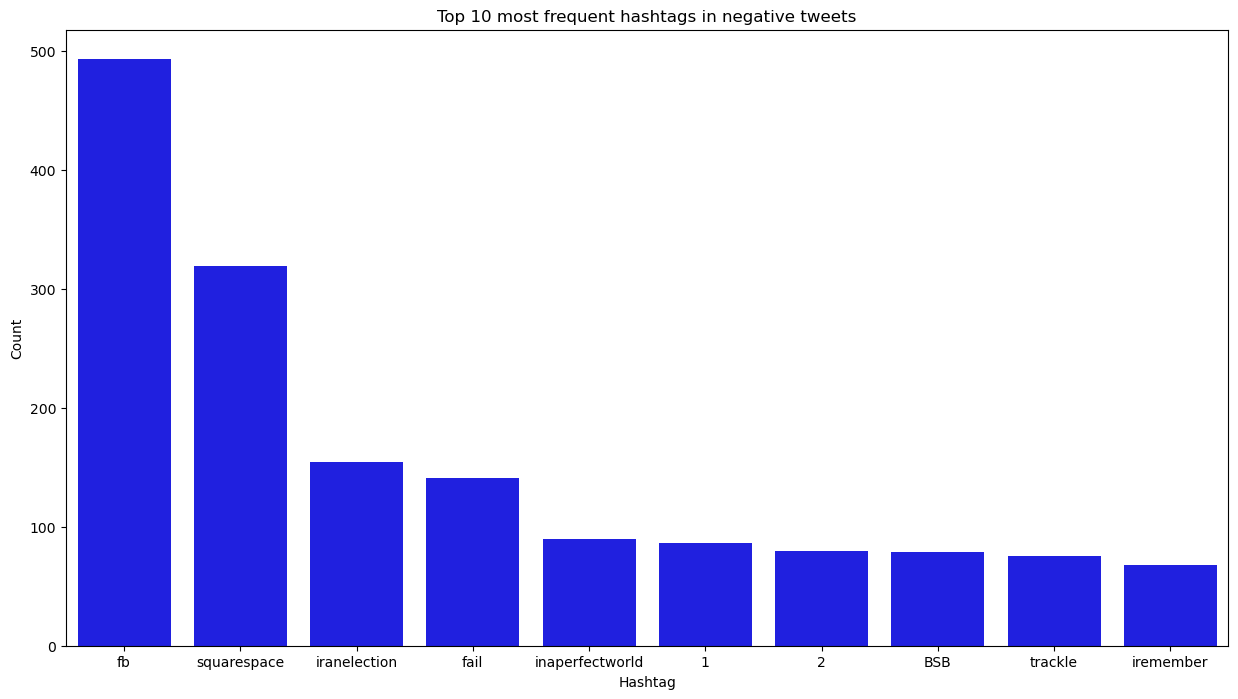

In [90]:
# selecting top 10 most frequent hashtags negative
d = d.nlargest(columns="Count", n = 10)
plt.figure(figsize=(15,8))
sns.barplot(data=d, x= "Hashtag", y = "Count", color="blue")
plt.title('Top 10 most frequent hashtags in negative tweets')

## **2. Feature engineering** 

In [8]:
data = x_train.drop(['ID', 'Date', 'flag', 'User'], axis = 'columns')
data

,Text
810677,"working, listening to KMPS, happy my boss &amp..."
684982,We both know she is late for &quot;at 11&quot;
954730,don't bogart that joint my friend ? http://bl...
142760,I'm so sick of being sick! I don't want to mis...
200331,im pretty sure i went to bed about... 2 hours ...
...,...
1023596,Good morning sunshine!! http://myloc.me/1oef
281932,@MassageAlumni Is the website (http://www.mass...
828817,@bringsatowel I listened to the iTunes samples...
683555,@cedric_chee I use palringo for chat and Fring...


In [9]:
#data['Target'] = data['Target'].replace(4, 1)
#data

In [10]:
# removing unnecessary user tags
data['Text'] = data['Text'].replace(r"@\w+", "", regex=True)
data

,Text
810677,"working, listening to KMPS, happy my boss &amp..."
684982,We both know she is late for &quot;at 11&quot;
954730,don't bogart that joint my friend ? http://bl...
142760,I'm so sick of being sick! I don't want to mis...
200331,im pretty sure i went to bed about... 2 hours ...
...,...
1023596,Good morning sunshine!! http://myloc.me/1oef
281932,Is the website (http://www.massagealumni.com)...
828817,I listened to the iTunes samples..my fav albu...
683555,I use palringo for chat and Fring for Voice c...


In [11]:
# resolving contractions (and slang)
data['Text'] = data['Text'].apply(lambda x: contractions.fix(x))
data

,Text
810677,"working, listening to KMPS, happy my boss &amp..."
684982,We both know she is late for &quot;at 11&quot;
954730,do not bogart that joint my friend ? http://b...
142760,I am so sick of being sick! I do not want to m...
200331,i am pretty sure i went to bed about... 2 hour...
...,...
1023596,Good morning sunshine!! http://myloc.me/1oef
281932,Is the website (http://www.massagealumni.com)...
828817,I listened to the iTunes samples..my fav albu...
683555,I use palringo for chat and Fring for Voice c...


In [12]:
# removing punctuation marks
data['Text'] = data['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
data

,Text
810677,working listening to KMPS happy my boss amp th...
684982,We both know she is late for quotat 11quot
954730,do not bogart that joint my friend httpblipf...
142760,I am so sick of being sick I do not want to mi...
200331,i am pretty sure i went to bed about 2 hours a...
...,...
1023596,Good morning sunshine httpmylocme1oef
281932,Is the website httpwwwmassagealumnicom down ...
828817,I listened to the iTunes samplesmy fav albums...
683555,I use palringo for chat and Fring for Voice c...


In [13]:
# deleting websites
data['Text'] = data['Text'].apply(lambda x: re.sub(r'http\S+', '', x))
data

,Text
810677,working listening to KMPS happy my boss amp th...
684982,We both know she is late for quotat 11quot
954730,do not bogart that joint my friend
142760,I am so sick of being sick I do not want to mi...
200331,i am pretty sure i went to bed about 2 hours a...
...,...
1023596,Good morning sunshine
281932,Is the website down I cannot get it to load
828817,I listened to the iTunes samplesmy fav albums...
683555,I use palringo for chat and Fring for Voice c...


In [14]:
# lowercasing letters in the text
data['Text'] = data['Text'].str.lower()
data

,Text
810677,working listening to kmps happy my boss amp th...
684982,we both know she is late for quotat 11quot
954730,do not bogart that joint my friend
142760,i am so sick of being sick i do not want to mi...
200331,i am pretty sure i went to bed about 2 hours a...
...,...
1023596,good morning sunshine
281932,is the website down i cannot get it to load
828817,i listened to the itunes samplesmy fav albums...
683555,i use palringo for chat and fring for voice c...


In [17]:
# deleting words which have less characters than 2

#data['Text'] = data["Text"].apply(lambda x: " ".join([w for w in x.split() if len(w)>=2]))
#data

,Text
810677,working listening to kmps happy my boss amp th...
684982,we both know she is late for quotat 11quot
954730,do not bogart that joint my friend
142760,am so sick of being sick do not want to miss a...
200331,am pretty sure went to bed about hours ago and...
...,...
1023596,good morning sunshine
281932,is the website down cannot get it to load
828817,listened to the itunes samplesmy fav albums ar...
683555,use palringo for chat and fring for voice call...


In [15]:
# individual words considered as tokens
tokenized_tweet = data['Text'].apply(lambda x: x.split())
tokenized_tweet

810677     [working, listening, to, kmps, happy, my, boss...
684982     [we, both, know, she, is, late, for, quotat, 1...
954730            [do, not, bogart, that, joint, my, friend]
142760     [i, am, so, sick, of, being, sick, i, do, not,...
200331     [i, am, pretty, sure, i, went, to, bed, about,...
                                 ...                        
1023596                            [good, morning, sunshine]
281932     [is, the, website, down, i, cannot, get, it, t...
828817     [i, listened, to, the, itunes, samplesmy, fav,...
683555     [i, use, palringo, for, chat, and, fring, for,...
603860     [i, am, uploading, photos, of, my, friendsbut,...
Name: Text, Length: 513801, dtype: object

In [16]:
# Initialize wordnet lemmatizer only on verbs - makes the biggest sense
wnl = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda s: [wnl.lemmatize(word, pos='v') for word in s]) # lemmatization

In [17]:
# combining to sentences
combined_sentences = [' '.join(tokens) for tokens in tokenized_tweet]
data['combined_tweet'] = combined_sentences

In [18]:
data

,Text,combined_tweet
810677,working listening to kmps happy my boss amp th...,work listen to kmps happy my boss amp the mech...
684982,we both know she is late for quotat 11quot,we both know she be late for quotat 11quot
954730,do not bogart that joint my friend,do not bogart that joint my friend
142760,i am so sick of being sick i do not want to mi...,i be so sick of be sick i do not want to miss ...
200331,i am pretty sure i went to bed about 2 hours a...,i be pretty sure i go to bed about 2 hours ago...
...,...,...
1023596,good morning sunshine,good morning sunshine
281932,is the website down i cannot get it to load,be the website down i cannot get it to load
828817,i listened to the itunes samplesmy fav albums...,i listen to the itunes samplesmy fav albums be...
683555,i use palringo for chat and fring for voice c...,i use palringo for chat and fring for voice ca...


In [19]:
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
bow_vectorizer = CountVectorizer(max_df = 0.95, min_df = 2, max_features = 1000, stop_words='english')
bow = bow_vectorizer.fit_transform(data['combined_tweet'])

In [21]:
bow.shape    , y_train.shape

((513801, 1000), (513801,))

In [22]:
x_train = bow

## **4. Modeling and validation**

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

In [26]:
#training
model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [27]:
x_valid = x_valid.drop(['ID', 'Date', 'flag', 'User'], axis = 'columns')
x_valid['Text'] = x_valid['Text'].replace(r"@\w+", "", regex=True)
x_valid['Text'] = x_valid['Text'].apply(lambda x: contractions.fix(x))
x_valid['Text'] = x_valid['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
x_valid['Text'] = x_valid['Text'].apply(lambda x: re.sub(r'http\S+', '', x))
x_valid['Text'] = x_valid['Text'].str.lower()
#x_valid['Text'] = x_valid['Text'].apply(lambda x: " ".join([w for w in x.split() if len(w) >= 2]))
tokenized_tweet = x_valid['Text'].apply(lambda x: x.split())
tokenized_tweet = tokenized_tweet.apply(lambda s: [wnl.lemmatize(word, pos='v') for word in s])
combined_sentences = [' '.join(tokens) for tokens in tokenized_tweet]
x_valid['combined_tweet'] = combined_sentences
bow_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(x_valid['combined_tweet'])
x_valid = bow

In [28]:
#testing
pred=  model.predict(x_valid)

In [29]:
from sklearn.metrics import f1_score
f1_score(y_valid, pred, pos_label=4)


0.1163489597700315

In [30]:
accuracy_score(y_valid,pred)

0.7235934441714615